In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, BlackLittermanModel
import yfinance as yf
import pypfopt
import os

In [2]:
data = {}
start_date = '2020-01-01'
end_date = '2020-12-31'

In [3]:
etfs = pd.read_csv('data/etfs.csv')

In [4]:
for i in range(len(etfs)):
    data[etfs.iloc[i, 0]] = yf.download(etfs.iloc[i, 0], period='max')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [71]:
np.log(data['GOLDBEES.NS']['Close']/data['GOLDBEES.NS']['Close'].shift(-1)).dropna().std()

0.1135131005533348

<AxesSubplot:xlabel='Date'>

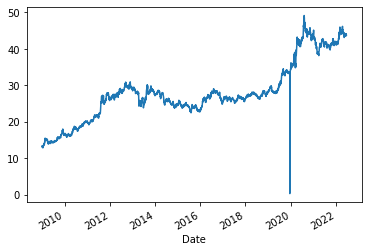

In [72]:
data['GOLDBEES.NS']['Close'].plot()

In [26]:
(np.log(data['GOLDBEES.NS']['Close'] /
                                   data['GOLDBEES.NS']['Close'].shift(-1)).dropna()).std()*np.sqrt(252)

1.8019646076719535

In [32]:
volatility_etfs = {}
for ticker in data:
    volatility_etfs[ticker] =np.log(abs(1 - (np.log(data[ticker]['Close'] /
                                   data[ticker]['Close'].shift(-1)).dropna())).std()*np.sqrt(252))*(-1)
#    volatility_etfs[ticker] = 1- np.log(data[ticker]['Close'].pct_change()).dropna()

In [33]:
volatility_etfs

{'GOLDBEES.NS': -0.38238726242298626,
 'BLV': 2.178188918043528,
 'VUSTX': 2.2182189517888293,
 'VNQ': 1.19361949701881,
 'VPU': 1.688983247192217,
 'VTI': 1.6311149614372786,
 'JUST': 1.5252542080352938,
 'BSV': 3.4710099170524256,
 'VGSH': 4.442999102103485,
 'VO': 1.548348003633747,
 'IVOG': 1.6267938389015184,
 'VBK': 1.4501449015732624,
 'VIOG': 1.5372683196749029}

In [102]:
for ticker in data:
    data[ticker].to_csv('data/' + ticker + '.csv')

for ticker in data:
    data[ticker]['percentageChange'] = data[ticker]['Close'].pct_change()*10
    data[ticker]['percentageChange'] = data[ticker]['percentageChange'].fillna(0)

In [103]:
onlyClosePrices = pd.DataFrame()
for ticker in data:
    onlyClosePrices[ticker] = data[ticker]['Close']

In [104]:
S = pypfopt.risk_models.CovarianceShrinkage(onlyClosePrices).ledoit_wolf()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import time #helper libraries

In [6]:
scalar = MinMaxScaler(feature_range=(-1, 1))

In [7]:
for ticker in data:
    print(ticker)
    data[ticker] = scalar.fit_transform(data[ticker])

GOLDBEES.NS
BLV
VUSTX
VNQ
VPU
VTI
JUST
BSV
VGSH
VO
IVOG
VBK
VIOG


In [8]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), -2]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
trainingData = {}
testData = {}

In [10]:
for ticker in data:
    trainingData[ticker], testData[ticker] = train_test_split(data[ticker], test_size=0.05, shuffle=False)

In [11]:
trainX, trainY = {}, {}
testX, testY = {}, {}
timeStep = 20
for ticker in data:
    trainX[ticker], trainY[ticker] = create_dataset(trainingData[ticker], timeStep)
    testX[ticker], testY[ticker] = create_dataset(testData[ticker], timeStep)

In [12]:
trainX['VTI'].shape

(5000, 20)

In [13]:
models = {}
for ticker in data:
    models[ticker] = Sequential()
    models[ticker].add(LSTM(units=100, return_sequences=True, input_shape=(trainX['VTI'].shape[1], 1)))
    models[ticker].add(Dropout(0.2))
    models[ticker].add(LSTM(50, return_sequences=False))
    models[ticker].add(Dropout(0.2))
    models[ticker].add(Dense(1))
    models[ticker].add(Activation('linear'))
    models[ticker].compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.8), metrics=[tf.keras.metrics.RootMeanSquaredError()])
"""model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(trainX['VTI'].shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.8), metrics=[tf.keras.metrics.RootMeanSquaredError()])
#model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9), metrics=[tf.keras.metrics.RootMeanSquaredError()])"""

"model = Sequential()\nmodel.add(LSTM(units=100, return_sequences=True, input_shape=(trainX['VTI'].shape[1], 1)))\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(units=50, return_sequences=True))\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(units=50, return_sequences=True))\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(units=50))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(units=1))\nmodel.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.8), metrics=[tf.keras.metrics.RootMeanSquaredError()])\n#model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9), metrics=[tf.keras.metrics.RootMeanSquaredError()])"

In [14]:
VERSION = '4'
for ticker in data:
    models[ticker].fit(trainX[ticker], trainY[ticker], epochs=100, batch_size=5, verbose=1, validation_data=(testX[ticker], testY[ticker]))
    models[ticker].save('models/' + ticker + '_' + VERSION + '.h5')
    models[ticker].evaluate(testX[ticker], testY[ticker])
    models[ticker].save_weights('weights/' + ticker + '_' + VERSION + '_weights.h5')

Epoch 1/100


In [ ]:
model = load_model('VTI.h5')

In [22]:
viewDict = {}

In [24]:
models = {}
for ticker in data:
    print(ticker)
    models[ticker] = load_model(ticker + '.h5')
    viewDict[ticker] = model.predict(testX[ticker])

VTI
VTV
VOE
VBR
GBIL


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
trainX['VTI'].shape

In [ ]:
viewDict['VTI']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
import yfinance as yf
import pandas_datareader as pdr
import seaborn as sns
import random

In [42]:
netAssets = {}
for ticker in data:
    netAssets[ticker] = yf.Ticker(ticker).info['totalAssets']

In [56]:
temp = yf.Ticker('GOLDBEES.NS').info

In [57]:
temp

{'exchange': 'NSI',
 'shortName': 'NIPPON INDIA MF',
 'longName': 'Nippon India ETF Gold BeES',
 'exchangeTimezoneName': 'Asia/Kolkata',
 'exchangeTimezoneShortName': 'IST',
 'isEsgPopulated': False,
 'gmtOffSetMilliseconds': '19800000',
 'quoteType': 'EQUITY',
 'symbol': 'GOLDBEES.NS',
 'messageBoardId': 'finmb_105326790',
 'market': 'in_market',
 'previousClose': 44.08,
 'regularMarketOpen': 44.06,
 'twoHundredDayAverage': 42.6711,
 'trailingAnnualDividendYield': 0,
 'payoutRatio': None,
 'volume24Hr': None,
 'regularMarketDayHigh': 44.06,
 'navPrice': None,
 'averageDailyVolume10Day': 2160827,
 'totalAssets': None,
 'regularMarketPreviousClose': 44.08,
 'fiftyDayAverage': 44.3284,
 'trailingAnnualDividendRate': 0,
 'open': 44.06,
 'toCurrency': None,
 'averageVolume10days': 2160827,
 'expireDate': None,
 'yield': None,
 'algorithm': None,
 'dividendRate': None,
 'exDividendDate': None,
 'beta': None,
 'circulatingSupply': None,
 'startDate': None,
 'regularMarketDayLow': 43.74,
 'pr

In [58]:
netAssets['GOLDBEES.NS'] = 6750.09*10000000

In [53]:
temp = yf.Ticker('NAV').info

In [54]:
temp

{'regularMarketPrice': None, 'preMarketPrice': None, 'logo_url': ''}

In [49]:
netAssets['NAV'] = yf.Ticker('NAV').info['totalAssets']

KeyError: 'totalAssets'

In [59]:
csvAssets = pd.DataFrame.from_dict(netAssets,orient='index')
csvAssets.to_csv('data/assets.csv')

In [ ]:
csvAssets = pd.read_csv('assets.csv', index_col=0)

In [ ]:
csvAssets['0']['VTI']

In [ ]:
delta = pypfopt.black_litterman.market_implied_risk_aversion(pd.Series(netAssets), risk_free_rate=0.05796)

In [ ]:
marketPrior = pypfopt.black_litterman.market_implied_prior_returns(netAssets, delta, S)

In [ ]:
viewDict = {}
confidence = []
for ticker in data:
    pred = models[ticker].predict(testX[ticker])
    viewDict[ticker] = (pred[-1,0] - testX[ticker][-2, 0])/testX[ticker][-2, 0]
    confidence.append(1-model.evaluate(testX[ticker], testY[ticker])[1])

In [ ]:
viewDict

In [ ]:
bl = pypfopt.black_litterman.BlackLittermanModel(S, pi=marketPrior, absolute_views=viewDict, rho=delta)

In [ ]:
bl_confi = pypfopt.BlackLittermanModel(S, absolute_views=viewDict, omega="idzorek", rho=delta, view_confidences=confidence)

In [ ]:
bl_return_confi = bl_confi.bl_returns()
bl_return_confi.name = 'BL Returns with Confidence'

In [ ]:
S_bl_confi = bl_confi.bl_cov()

In [ ]:
ef = pypfopt.EfficientFrontier(bl_return_confi, S_bl_confi, weight_bounds=(0, 0.2))

In [ ]:
#ef.add_objective('Sharpe', 'max')
weights = ef.min_volatility()
ef.portfolio_performance(verbose=True)

In [ ]:
import json
json.dumps(weights)

In [ ]:
wt_min_vola = pd.DataFrame([weights], columns=weights.keys()).T*100
print ('Weights in Percentage ********************')
print(wt_min_vola.round(4))

In [ ]:
data

In [39]:
onlyClosePrices = pd.DataFrame()
for ticker in data:
    onlyClosePrices[ticker] = data[ticker]['Close']

In [40]:
S = pypfopt.risk_models.CovarianceShrinkage(onlyClosePrices).ledoit_wolf()

In [41]:
S

,GOLDBEES.NS,BLV,VUSTX,VNQ,VPU,VTI,JUST,BSV,VGSH,VO,IVOG,VBK,VIOG
GOLDBEES.NS,57.328927,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
BLV,-0.000000,57.328927,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
VUSTX,-0.000000,0.000000,57.328927,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
VNQ,-0.000000,-0.000000,-0.000000,57.328927,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
VPU,-0.000000,0.000000,-0.000000,0.000000,57.328927,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
VTI,-0.000000,-0.000000,-0.000000,0.000000,0.000000,57.328927,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
JUST,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,57.328927,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
BSV,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,57.328927,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
VGSH,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,57.328927,-0.000000,-0.000000,-0.000000,-0.000000
VO,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,57.328927,0.000000,0.000000,0.000000
